In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


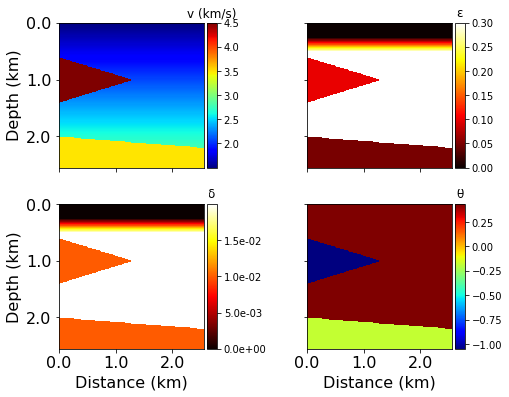

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, TimeAxis
from plot_parameters import plot

# Define a physical size
shape = (256, 256)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

space_order=8
t0=0.
tn=1500.

#Load the velocity model and thomsem parameters
v = np.fromfile('models/new_models/vel.bin',dtype='float32')
epsilon = np.fromfile('models/new_models/epsilon.bin', dtype=np.float32)
delta = np.fromfile('models/new_models/delta.bin',dtype=np.float32)
theta = np.fromfile('models/new_models/theta.bin', dtype=np.float32)

v = np.reshape(v, shape)
epsilon = np.reshape(epsilon, shape)
delta = np.reshape(delta, shape)
theta = np.reshape(theta, shape)

# With the velocity, delta, epsilon, theta, phi and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 40 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbpml=40, epsilon=epsilon, delta=delta,
                  theta=theta)

plot(v,epsilon,delta,theta)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


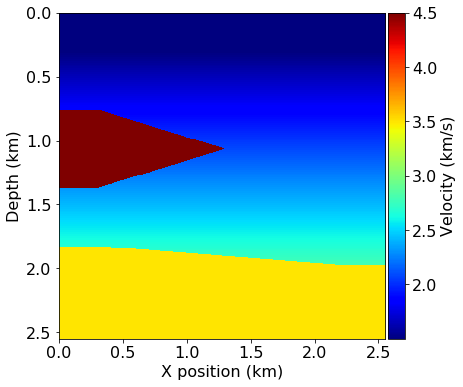

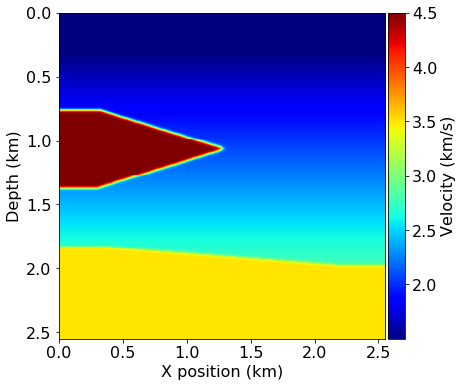

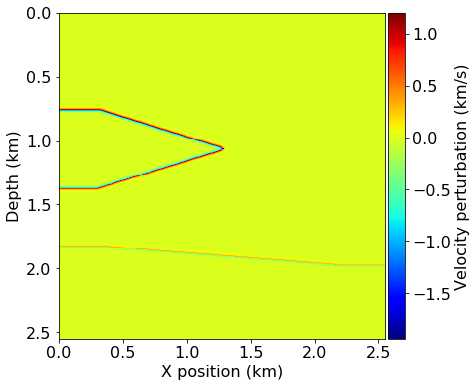

In [3]:
from scipy import ndimage
from examples.seismic import plot_velocity, plot_perturbation

model0 = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbpml=40, epsilon=epsilon, delta=delta,
                  theta=theta)

filter_sigma = (1, 1)
for i in range(2):
    model0.vp = ndimage.gaussian_filter(model0.vp.data, sigma=filter_sigma, order=0)
    
# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

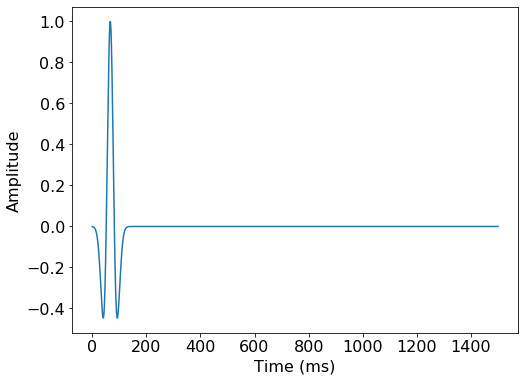

In [15]:
from examples.seismic import Model, AcquisitionGeometry

nshots=10
src_coordinates = np.empty((nshots, 2), dtype=np.float32)
src_coordinates[:, 0] = np.linspace(0., 2550, num=nshots)
src_coordinates[0, -1] = model.origin[-1] + 2 * spacing[-1]

nrec = shape[0]
rec_coordinates = np.empty((nrec, len(spacing)))
rec_coordinates[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec_coordinates[:, 1] = np.array(model.domain_size)[1] * .5
rec_coordinates[:, -1] = model.origin[-1] + 2 * spacing[-1]

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                                   t0=t0, tn=tn, src_type='Ricker', f0=0.015)
dt = model.critical_dt
# We can plot the time signature to see the wavelet
geometry.src.show()

In [14]:
from sympy import cos, sin, sqrt
from examples.seismic import PointSource, Receiver, RickerSource
from examples.seismic.tti.operators import kernel_centered_2d, Gxx_centered_2d,Gzz_centered_2d
from devito import TimeFunction
from devito import Eq, Operator, TimeFunction
from devito import ConditionalDimension

save=True
time_order=2
stagg_u = stagg_v = None
u = TimeFunction(name='u', grid=model.grid, staggered=stagg_u,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)
v = TimeFunction(name='v', grid=model.grid, staggered=stagg_v,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)

time_range=TimeAxis(start=0., stop=1500., step=dt)
src = RickerSource(name='src', grid=model.grid, f0=0.015,npoint=1, time_range=time_range)
rec = Receiver(name='rec', grid=model.grid, npoint=rec_coordinates.shape[0], time_range=time_range,
               coordinates=rec_coordinates)

stencils= kernel_centered_2d(model, u, v, space_order)

stencils += src.inject(field=u.forward, expr=src * dt**2 / model.m)
stencils += src.inject(field=v.forward, expr=src * dt**2 / model.m)
stencils += rec.interpolate(expr=u + v)

solver_tti = Operator(stencils, subs=model.spacing_map, name='ForwardTTI')

In [6]:
# Source and receiver geometries
#src_coordinates = np.empty((1, len(spacing)))
#src_coordinates[0, :] = np.array(model.domain_size) * .5

#nsnaps = 100               # desired number of equally spaced snaps
#nt = time_range.num
#print(nt)
#factor = round(nt / nsnaps)  # subsequent calculated factor
#print(f"factor is {factor}")

#time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)
#usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=space_order,
#                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)
#vsave = TimeFunction(name='vsave', grid=model.grid, time_order=2, space_order=space_order,
#                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)

#solver_tti = Operator(stencils+ [Eq(usave, u)] + [Eq(vsave, v)], subs=model.spacing_map, name='ForwardTTI')

#src.coordinates.data[0, :]=src_coordinates[0]# just the first source
#solver_tti(dt=model.critical_dt, rec=rec, src=src)
#g= open('shot_TTI.file', 'wb')
#print(rec.data.shape)
#np.transpose(rec.data).astype('float32').tofile(g)

#print("Saving snaps file")
#print("Dimensions: nz = {:d}, nx = {:d}".format(shape[-1] + 2 * model.nbpml, shape[0] + 2 * model.nbpml))
#filename = "snaps_TTI.bin"
#usave.data.tofile(filename)

In [7]:
#NBVAL_IGNORE_OUTPUT
#from examples.seismic import plot_shotrecord

#plot_shotrecord(rec.data, model, t0, tn)

In [8]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.tti import AnisotropicWaveSolver

solver_tti = AnisotropicWaveSolver(model, geometry, time_order=2,space_order=space_order)
true_d, _,_,_ =solver_tti.forward(save=True)

Operator `ForwardTTI` run in 24.88 s


In [9]:
# Compute initial data with forward operator 
smooth_d, _, _,_ = solver_tti.forward(vp=model0.vp,)

Operator `ForwardTTI` run in 24.39 s


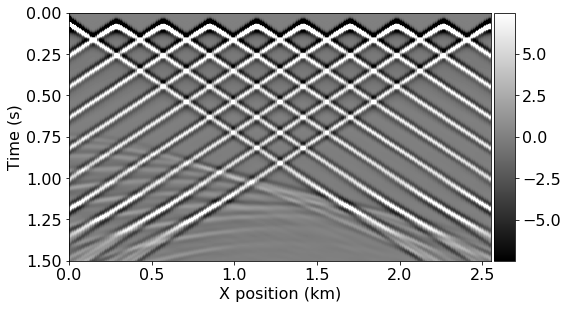

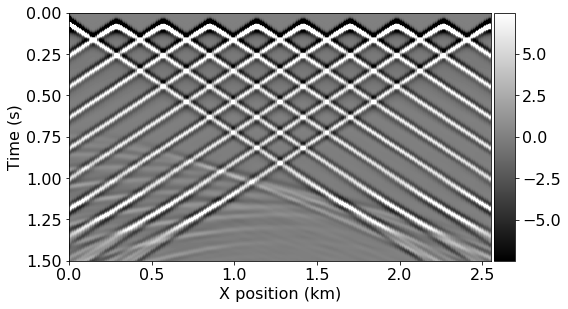

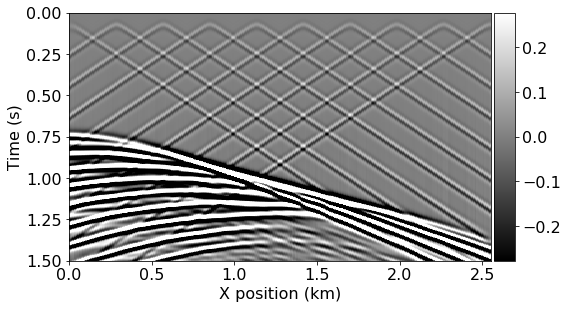

In [10]:
#NBVAL_IGNORE_OUTPUT
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [11]:
from sympy import cos, sin, sqrt
from examples.seismic import PointSource, Receiver, RickerSource
from examples.seismic.tti.operators import kernel_centered_2d, Gxx_centered_2d,Gzz_centered_2d
from devito import TimeFunction
from devito import Eq, Operator, TimeFunction
from devito import ConditionalDimension

def ImagingOperator(model, image):
    save=True
    time_order=2
    stagg_u = stagg_v = None
    
    u = TimeFunction(name='u', grid=model.grid, staggered=stagg_u,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)
    v = TimeFunction(name='v', grid=model.grid, staggered=stagg_v,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)
    
    uu = TimeFunction(name='uu', grid=model.grid, staggered=stagg_u,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)
    vv = TimeFunction(name='vv', grid=model.grid, staggered=stagg_v,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=space_order)

    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions) 

    stencils= kernel_centered_2d(model, uu, vv, space_order, forward=False)

    stencils += residual.inject(field=uu, expr=residual * dt**2 / model.m)
    stencils += residual.inject(field=vv, expr=residual * dt**2 / model.m)
    
    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - (u.dt2* uu + v.dt2*vv))
    return Operator(stencils + [image_update], subs=model.spacing_map)

In [12]:
from devito import Function, clear_cache
from examples.seismic.tti import AnisotropicWaveSolver

solver_tti = AnisotropicWaveSolver(model, geometry, time_order=2,space_order=space_order)

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)

# Create a wavefield for saving to avoid memory overload
u0 = TimeFunction(name='u', grid=model0.grid, staggered=None,time_order=2, space_order=8,
                  save=geometry.nt)
v0 = TimeFunction(name='v', grid=model0.grid, staggered=None,time_order=2, space_order=8,
                  save=geometry.nt)
for i in range(nshots):
    # Important: We force previous wavefields to be destroyed,
    # so that we may reuse the memory.
    clear_cache()
    
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    # Update source location
    geometry.src_positions[0, :] = src_coordinates[i, :]

    # Generate synthetic data from true model
    true_d, _, _,_ = solver_tti.forward(vp=model.vp, save=True)
    
    # Compute smooth data and full forward wavefield u0
    u0.data.fill(0.)
    v0.data.fill(0.)
    smooth_d, _, _,_ = solver_tti.forward(vp=model0.vp, save=True, u=u0, v=v0)
    
    # Compute gradient from the data residual  
    vv = TimeFunction(name='vv', grid=model.grid, staggered=None,time_order=2, space_order=8, save=geometry.nt)
    uu = TimeFunction(name='uu', grid=model.grid, staggered=None,time_order=2, space_order=8, save=geometry.nt)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v0,vv=vv, uu=uu, vp=model0.vp, dt=model0.critical_dt, 
               residual=residual)

Imaging source 1 out of 10


Operator `ForwardTTI` run in 24.91 s
Operator `ForwardTTI` run in 24.40 s
Operator `Kernel` run in 53.16 s


Imaging source 2 out of 10


Operator `ForwardTTI` run in 24.38 s
Operator `ForwardTTI` run in 24.46 s
Operator `Kernel` run in 52.71 s


Imaging source 3 out of 10


Operator `ForwardTTI` run in 24.55 s
Operator `ForwardTTI` run in 24.40 s
Operator `Kernel` run in 52.86 s


Imaging source 4 out of 10


Operator `ForwardTTI` run in 24.48 s
Operator `ForwardTTI` run in 24.41 s
Operator `Kernel` run in 52.87 s


Imaging source 5 out of 10


Operator `ForwardTTI` run in 24.43 s
Operator `ForwardTTI` run in 24.39 s
Operator `Kernel` run in 52.69 s


Imaging source 6 out of 10


Operator `ForwardTTI` run in 24.45 s
Operator `ForwardTTI` run in 24.44 s
Operator `Kernel` run in 52.66 s


Imaging source 7 out of 10


Operator `ForwardTTI` run in 24.38 s
Operator `ForwardTTI` run in 24.38 s
Operator `Kernel` run in 52.62 s


Imaging source 8 out of 10


Operator `ForwardTTI` run in 24.47 s
Operator `ForwardTTI` run in 24.40 s
Operator `Kernel` run in 52.71 s


Imaging source 9 out of 10


Operator `ForwardTTI` run in 24.47 s
Operator `ForwardTTI` run in 24.38 s
Operator `Kernel` run in 52.59 s


Imaging source 10 out of 10


Operator `ForwardTTI` run in 24.38 s
Operator `ForwardTTI` run in 24.39 s
Operator `Kernel` run in 52.80 s


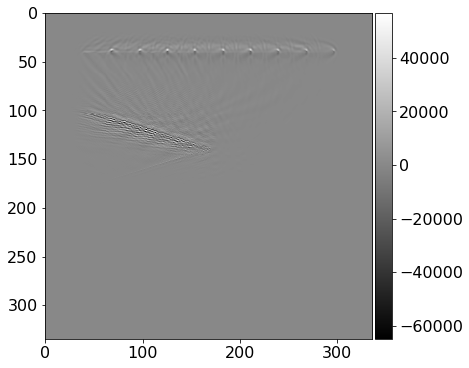

In [13]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

# Plot the inverted image
plot_image(np.diff(image.data, axis=1))